In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

# Load data
Load data from https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [20]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

# Visualize the images

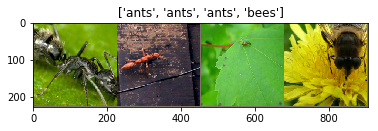

In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Train the model

In [48]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects/dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model
                
                

# Visualizing the model predictions

In [64]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

# Finetuning the convnet

In [55]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9)

#decay 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [56]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1557 Acc: 0.6762
val Loss: 0.0610 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.1569 Acc: 0.7500
val Loss: 0.1096 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.1234 Acc: 0.7992
val Loss: 0.0556 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.0985 Acc: 0.8443
val Loss: 0.0999 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.1147 Acc: 0.8115
val Loss: 0.0683 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.1662 Acc: 0.7336
val Loss: 0.1219 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.1351 Acc: 0.8197
val Loss: 0.0841 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.0892 Acc: 0.8484
val Loss: 0.0911 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.1141 Acc: 0.8074
val Loss: 0.0717 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.0850 Acc: 0.8689
val Loss: 0.0768 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.0776 Acc: 0.8811
val Loss: 0.0701 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.0809 Acc: 0.8525
val Loss: 0.0829 Acc: 0.8693

Ep

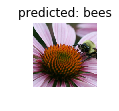

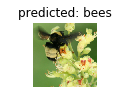

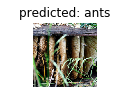

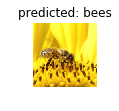

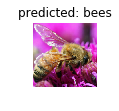

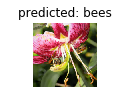

In [65]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [68]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [69]:
model_conv = train_model(model_conv, criterion, optimizer_conv, 
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1365 Acc: 0.7172
val Loss: 0.0539 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.1144 Acc: 0.8033
val Loss: 0.0568 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.0849 Acc: 0.8525
val Loss: 0.0448 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.1281 Acc: 0.7500
val Loss: 0.0530 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.1344 Acc: 0.7582
val Loss: 0.0540 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.0973 Acc: 0.8320
val Loss: 0.0461 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.0973 Acc: 0.8402
val Loss: 0.0579 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.0977 Acc: 0.8238
val Loss: 0.0451 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.0956 Acc: 0.8484
val Loss: 0.0432 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.0771 Acc: 0.8770
val Loss: 0.0479 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.0866 Acc: 0.8484
val Loss: 0.0513 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0900 Acc: 0.8238
val Loss: 0.0441 Acc: 0.9412

Ep

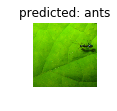

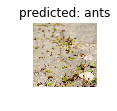

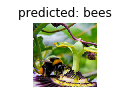

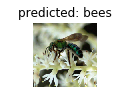

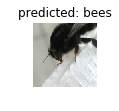

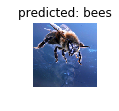

In [70]:
visualize_model(model_conv)

plt.ioff()
plt.show()